In [19]:
# Based on https://gist.github.com/AO8/63b9a5acb9fb238cbed13a0269d14137
# Collects and parses data posted by OC Health
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
from datetime import timedelta
import json

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [20]:
url = "https://occovid19.ochealthinfo.com/coronavirus-in-oc"
out_filename = "oc_data.json"

def get_todays_info(the_url):
    html = urlopen(url)
    soup = BeautifulSoup(html, "html.parser")
    tables = soup.findAll("table")
    tests_table = tables[0]
    city_table = tables[1]
    demo_table = tables[2]
    return (tests_table, city_table, demo_table, soup)

def html_table_to_list(table):
    list_table = []
    for row in table.findAll("tr"):
        row_table = []
        for cell in row.findAll(["td", "th"]):
            row_table.append(cell.get_text())
        list_table.append(row_table)
    return list_table

def get_todays_lists(the_url):
    tables = get_todays_info(the_url)
    the_lists = [html_table_to_list(table) for table in tables]
    todays_date_string = str(tables[-1].text.split('Posted Date:')[-1].split('\n')[0].replace(' ',''))
    return the_lists, todays_date_string

def get_todays_json(the_url):
    # Get top-line stats
    total_cases = int(get_todays_info(url)[-1].findAll('h1')[3].text.replace(',', '').strip())
    deaths = int(get_todays_info(url)[-1].findAll('h1')[4].text.strip())
    # Get lists from today's tables
    todays_lists, todays_date_string = get_todays_lists(the_url)
    
    todays_json = {}
    todays_json["date"] = todays_date_string
    todays_json["cumulative_cases"] = total_cases
    todays_json["cumulative_deaths"] = deaths
    todays_json["tests"] = {}
    todays_json["populations"] = {}
    todays_json["city_cases"] = {}
    for row in todays_lists[1][1:]:
        if row[0] != 'Total Population':
            todays_json["city_cases"][row[0]] = int(row[-1].replace(',', '').replace('***', '-1'))
    for row in todays_lists[1][1:-5]:
        todays_json["populations"][row[0]] = int(row[1].replace(',', '').replace("Not Available", "-1"))
    todays_json["tests"]["people_tested"] = int(todays_lists[0][0][-1].replace(',', ''))
    todays_json["tests"]["kits_available"] = int(todays_lists[0][1][-1].replace(',', '').replace('specimens',''))

    todays_json["Stats"] = {}
    rows = ["TotalCases", "Deaths", "TravelRelated", "PersonToPerson", "CommunityAcquired", "UnderInvestigation"]
    cols = ["Total", "Male", "Female", "OtherGender", "Under18", "18to49", "50to64", "65andUp", "UnknownAge"]
    for i,row in enumerate(todays_lists[2][3:-1]):
        todays_json["Stats"][rows[i]] = {}
        for j,col in enumerate(cols):
            todays_json["Stats"][rows[i]][cols[j]] = int(row[j+1].replace('\n','').replace(',',''))
    print(todays_date_string)
    return todays_date_string, todays_json

def append_todays_json(the_out_filename, the_url):
    date_string, todays_json = get_todays_json(url)
    with open(the_out_filename, 'r') as saved_json_file:
        saved_json = json.load(saved_json_file)
    if date_string not in saved_json:
        out_json = saved_json
        out_json[date_string] = todays_json
        with open(the_out_filename, 'w') as out_json_file:
            json.dump(out_json, out_json_file)

def load_oc_data(the_out_filename):
    with open(the_out_filename, 'r') as saved_json_file:
        saved_json = json.load(saved_json_file)
        return saved_json

def get_city_time_series(the_json):
    date_strings = the_json.keys()
    deaths = []
    dates = []
    total_cases = []
    for date_string in date_strings:
        date_list = date_string.split('/')
        dates.append(datetime.datetime(int(date_list[-1]), 
                                       int(date_list[0]), int(date_list[1])))
        deaths.append(the_json[date_string]['cumulative_deaths'])
        total_cases.append(the_json[date_string]['cumulative_cases'])

    cities = []
    city_case_series = {}
    for city in the_json[list(date_strings)[0]]['city_cases']:
        cities.append(city)
        city_case_series[city] = []

    for date_string in date_strings:
        for city in cities:
            city_case_series[city].append(the_json[date_string]['city_cases'][city])

    return dates, deaths, total_cases, city_case_series, the_json


In [21]:
# First time, just output a base file
# todays_json = get_todays_json(url)
# json_base = {}
# json_base["March 26, 2020"] = todays_json
# with open(out_filename, 'w') as file:
#     json.dump(json_base, file)

In [22]:
# Append to the base file if today's data is different
append_todays_json(out_filename, url)

4/16/2020


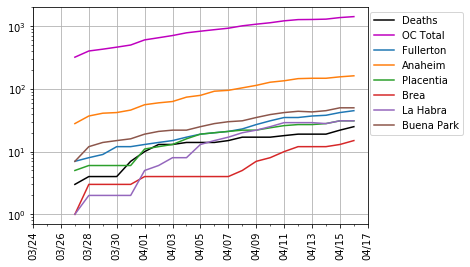

In [34]:
# Plot city data on a log scale
oc_data = load_oc_data(out_filename)

dates, deaths, total_cases, city_series, my_json = get_city_time_series(oc_data)

plt.clf()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.plot_date(dates, deaths, "-k", label = 'Deaths')
plt.plot_date(dates, total_cases, "-m", label = 'OC Total')
for city in ['Fullerton', 'Anaheim', "Placentia", 'Brea', 'La Habra', 'Buena Park']:
    plt.plot_date(dates, city_series[city], "-", label=city)
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1))
plt.xlim(dates[0]-datetime.timedelta(days=3), dates[-1]+timedelta(days=1))
plt.yscale('log')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [29]:
?mdates.DayLocator

Init signature: mdates.DayLocator(bymonthday=None, interval=1, tz=None)
Docstring:     
Make ticks on occurrences of each day of the month.  For example,
1, 15, 30.
Init docstring:
Mark every day in *bymonthday*; *bymonthday* can be an int or
sequence.

Default is to tick every day of the month: ``bymonthday=range(1,32)``
File:           ~/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/dates.py
Type:           type
Subclasses:     
